In [1]:
import numpy as np
import casadi


In [36]:
def model(x,u):
    phi_1= x[0,:]
    phi_2= x[1,:]
    phi_3= x[2,:]
    dphi_1= x[3,:]
    dphi_2= x[4,:]
    dphi_3= x[5,:]
    phi_1_m= x[6,:]
    phi_2_m= x[7,:]

    phi_m_1_set = u[0,:]
    phi_m_2_set = u[1,:]

    theta_1 = theta_2 = theta_3 = 2.25e-4
    c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
    d = np.array([6.78,  8.01,  8.82])*1e-5
    tau = 1e-2
    return casadi.vertcat(
        dphi_1,
        dphi_2,
        dphi_3,
        -c[0]/theta_1*(phi_1-phi_1_m)-c[1]/theta_1*(phi_1-phi_2)-d[0]/theta_1*dphi_1,
        -c[1]/theta_2*(phi_2-phi_1)-c[2]/theta_2*(phi_2-phi_3)-d[1]/theta_2*dphi_2,
        -c[2]/theta_3*(phi_3-phi_2)-c[3]/theta_3*(phi_3-phi_2_m)-d[2]/theta_3*dphi_3,
        1/tau*(phi_m_1_set - phi_1_m),
        1/tau*(phi_m_2_set - phi_2_m)
    )

In [70]:
import casadi as ca

class DynamicsModel(ca.Callback):
	def __init__(self, name, opts={}):
		ca.Callback.__init__(self)
		self.construct(name, opts)
		self.theta  = 2.25e-4
		self.c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
		self.d = np.array([6.78,  8.01,  8.82])*1e-5
		self.tau = 1e-2
	# Number of inputs and outputs
	def get_n_in(self): return 2
	def get_n_out(self): return 1

	def get_sparsity_in(self,i):		
		if i==0:
			return ca.Sparsity.dense(8,1)
		elif i==1:
			return ca.Sparsity.dense(2,1)
		else:
			return ca.Sparsity.dense(8,1)

	def get_sparsity_out(self,i):
		return ca.Sparsity.dense(8,1)

	# Initialize the object
	def init(self):
		print('initializing object')

	# Evaluate numerically
	def eval(self, arg):
		print(len(arg))
		phi_1,phi_2,phi_3,dphi_1,dphi_2,dphi_3,phi_1_m,phi_2_m = ca.vertsplit(arg[0])
		phi_m_1_set,phi_m_2_set = ca.vertsplit(arg[1])

		return [ca.vertcat(
			dphi_1,
			dphi_2,
			dphi_3,
			-self.c[0]/self.theta*(phi_1-phi_1_m)-self.c[1]/self.theta*(phi_1-phi_2)-self.d[0]/self.theta*dphi_1,
			-self.c[1]/self.theta*(phi_2-phi_1)-self.c[2]/self.theta*(phi_2-phi_3)-self.d[1]/self.theta*dphi_2,
			-self.c[2]/self.theta*(phi_3-phi_2)-self.c[3]/self.theta*(phi_3-phi_2_m)-self.d[2]/self.theta*dphi_3,
			1/self.tau*(phi_m_1_set - phi_1_m),
			1/self.tau*(phi_m_2_set - phi_2_m)
		)]

In [74]:
x0 = ca.pi*ca.DM([[1, 1, -1.5, 1, -1, 1, 0, 0],[1, 1, -1.5, 1, -1, 1, 0, 0]]).T
u0 = ca.pi*ca.DM([[-1, 0.2],[-5, 0.3]]).T
#print(x0)
#print(u0)
dynamics_model = DynamicsModel('model')
dynamics_model(x0,u0)
#timeit.timeit(lambda: dynamics_model(x0,u0))
#%timeit dynamics_model(x0,u0)



initializing object
2
2


DM(
[[3.14159, 3.14159], 
 [-3.14159, -3.14159], 
 [3.14159, 3.14159], 
 [-38.6039, -38.6039], 
 [-105.347, -105.347], 
 [165.133, 165.133], 
 [-314.159, -1570.8], 
 [62.8319, 94.2478]])

In [52]:
print(model(x0,u0))
%timeit model(x0,u0)


[[3.14159, 3.14159], 
 [-3.14159, -3.14159], 
 [3.14159, 3.14159], 
 [-38.6039, -38.6039], 
 [-105.347, -105.347], 
 [165.133, 165.133], 
 [-314.159, -1570.8], 
 [62.8319, 94.2478]]
253 µs ± 3.92 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [75]:

horizon = 50
nx = 8
nu = 2
dt = 0.05
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)

option = {}
option['max_iter']=10000

#option['print_level']=0

opti = casadi.Opti()
x = opti.variable(nx,horizon+1)
u = opti.variable(nu,horizon)

phi_1= x[0,:]
phi_2= x[1,:]
phi_3= x[2,:]
dphi_1= x[3,:]
dphi_2= x[4,:]
dphi_3= x[5,:]
phi_1_m= x[6,:]
phi_2_m= x[7,:]

phi_m_1_set = u[0,:]
phi_m_2_set = u[1,:]

k1 = model(x[:,0:-1],u)
k2 = model(x[:,0:-1]+dt/2*k1,u)
k3 = model(x[:,0:-1]+dt/2*k2,u)
k4 = model(x[:,0:-1]+dt*k3,u)

opti.minimize(casadi.dot(phi_1,phi_1)+casadi.dot(phi_2,phi_2)+casadi.dot(phi_3,phi_3)
              +0.001*casadi.dot(phi_m_1_set,phi_m_1_set)+0.1*casadi.dot(phi_m_2_set,phi_m_2_set)
              +0.001*casadi.dot(phi_1_m,phi_1_m)+0.1*casadi.dot(phi_2_m,phi_2_m))

opti.subject_to(x[:,1:] == x[:,0:-1]+dt/6*(k1+2*k2+2*k3+k4))

opti.subject_to(x[:,0]==x0)

opti.subject_to(opti.bounded(-2*casadi.pi,phi_1,2*casadi.pi))
opti.subject_to(opti.bounded(-2*casadi.pi,phi_2,2*casadi.pi))
opti.subject_to(opti.bounded(-2*casadi.pi,phi_3,2*casadi.pi))

opti.subject_to(opti.bounded(-2*casadi.pi,phi_1_m,2*casadi.pi))
opti.subject_to(opti.bounded(-2*casadi.pi,phi_1_m,2*casadi.pi))


opti.subject_to(opti.bounded(-2*casadi.pi,phi_m_1_set,2*casadi.pi))
opti.subject_to(opti.bounded(-2*casadi.pi,phi_m_2_set,2*casadi.pi))



opti.solver("ipopt",{},option)

try:
    sol = opti.solve()

except Exception as e:
    print(e)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3008
Number of nonzeros in inequality constraint Jacobian.:      355
Number of nonzeros in Lagrangian Hessian.............:      355

Total number of variables............................:      508
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

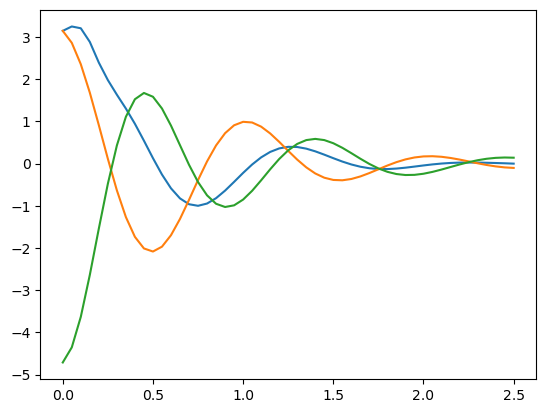

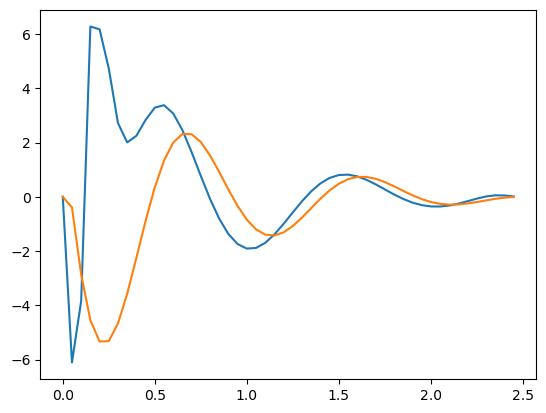

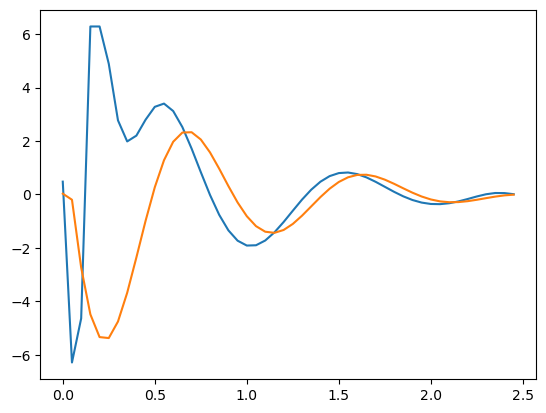

In [76]:
import matplotlib.pyplot as plt
t = np.linspace(0,dt*horizon,horizon+1)
plt.figure(1)
plt.plot(t,sol.value(phi_1))
plt.plot(t,sol.value(phi_2))
plt.plot(t,sol.value(phi_3))
plt.figure(2)
plt.plot(t[0:-1],sol.value(phi_1_m)[0:-1])
plt.plot(t[0:-1],sol.value(phi_2_m)[0:-1])
plt.figure(3)
plt.plot(t[0:-1],sol.value(phi_m_1_set))
plt.plot(t[0:-1],sol.value(phi_m_2_set))
plt.show()


In [5]:
x=casadi.MX.sym('x',nx,1)
u=casadi.MX.sym('u',nu,1)
dae = {'x':x, 'p':u, 'ode':model(x,u)}
opts = {'tf':dt}
F = casadi.integrator('F', 'cvodes', dae,opts)

F(x0=x0,p=[1.0,1.0])

{'qf': DM([]),
 'rqf': DM([]),
 'rxf': DM([]),
 'rzf': DM([]),
 'xf': DM([3.25836, 2.85809, -4.34361, 1.55498, -8.07071, 11.5465, 0.99326, 0.99326]),
 'zf': DM([])}

In [11]:
t=np.random.randint(low=2,high=100,size=100)
print(t)
u_value = np.random.uniform(-2*np.pi+0.01,2*np.pi-0.01,2)
dict = F(x0=x0,p=u_value)
print(dict)
x0 = dict['xf']
#noise = 0.01*np.pi*np.random.uniform(-1,1,nx)
#x0=np.array(x0)+noise.reshape(-1,1)
result = np.concatenate((x0,u_value.reshape(-1,1)),axis=0)
print(result.shape)


for i in t:
    u_value = np.random.uniform(-2*np.pi+0.01,2*np.pi-0.01,2)
    for j in range(i):
        dict = F(x0=x0,p=u_value)
        x0 = dict['xf']

        #noise = 0.01*np.pi*np.random.uniform(-1,1,nx)
        #x0=np.array(x0)+noise.reshape(-1,1)
        v = np.concatenate((x0,u_value.reshape(-1,1)),axis=0)
        #print(v.shape)
        result=np.concatenate((result,v),axis=1)

print(result.shape)
result = result.T
np.savetxt("foo_valid.csv", result, delimiter=",")



[84 22 52 70 14 99 77 81 12 27 29 58 32 55 74 30 30 47 16 99 54 13  3 44
  4 86 40  5 44 55 93 72 33 29 34 31 24 75 82 90 97 97 45 95 74 48 43  5
 19 98 34 75 38 80 72  2 37 49 52 48 51 32 18 81 29  8 40 72 82 51 21 75
  3 96 84 18 20 26 29 44 55 37 89 18 88 96 58 44 41 87 40 96 84 31 79 46
 76  5 51 76]
{'qf': DM([]), 'rqf': DM([]), 'rxf': DM([]), 'rzf': DM([]), 'xf': DM([0.364398, 4.30296, 5.22291, -19.268, -19.3258, -25.5767, -2.23953, -1.45948]), 'zf': DM([])}
(10, 1)
(10, 5105)


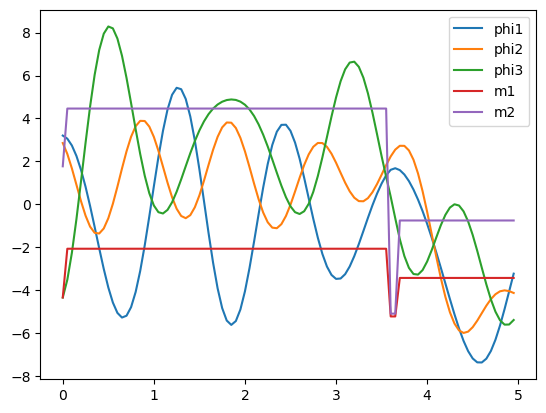

In [10]:
t = np.linspace(0,dt*99,99+1)
plt.figure(1)
plt.plot(t,result[0:100,0],label='phi1')
plt.plot(t,result[0:100,1],label='phi2')
plt.plot(t,result[0:100,2],label='phi3')
plt.plot(t,result[0:100,-2],label='m1')
plt.plot(t,result[0:100,-1],label='m2')
plt.legend()



plt.show()